In [1]:
from __future__ import absolute_import, print_function, unicode_literals
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, HTML
import copy
sys.path.append('/home/janekg89/Develop/Pycharm_Projects/flutype_webapp')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "flutype_webapp.settings")
import django
django.setup()
from flutype.models import Spot


****************************************
RUNNING IN DEVELOP
****************************************


/home/janekg89/Envs/flutype_webapp3/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
studies = ["microarray_2018_01_24"]
spots = Spot.objects.filter(raw_spot__raw_spot_collection__studies__sid__in=studies)

In [3]:
#reformat data and a replica column
data = a.Data._reformat(spots)
a.Data._add_replica_row(data)

NameError: name 'a' is not defined

In [56]:
#create datasets for experiments
data_test = copy.deepcopy(data)
background_data = data_test[data_test["Ligand Batch"].isnull()] #background
data_test.dropna(inplace=True)
data_test.reset_index(drop=True, inplace=True)

In [57]:
#create new features from intensitiy difference between same peptides but different concentrations 
grouped_features = {}
max_i = 0
for i,spot in data_test[["Collection","Block","Replica","Ligand"]].iterrows():
    max_i = max(i, max_i)
    key = tuple(spot.values)
    value = grouped_features.get(key,[])
    value.append(i)
    grouped_features[key] = value

data_test["Constructed Feature"]=False
for lig_indexes in grouped_features:
    temp_data = data_test.loc[grouped_features[lig_indexes]]
    new_feature = copy.deepcopy(temp_data.iterrows().next()[1])
    new_feature["Ligand Batch"] = new_feature["Ligand Batch"] + temp_data["Ligand Batch"].values[2]
    new_feature["Intensity"] = new_feature["Intensity"] - temp_data["Intensity"].values[2]
    new_feature["Ligand Batch Concentration"] = np.NaN
    new_feature["Constructed Feature"] = True
    data_test = data_test.append(new_feature, ignore_index=True)

In [410]:
#normalize
from scipy.stats import norm
import matplotlib.mlab as mlab

constructed_data = data_test[data_test["Constructed Feature"]== True]
histograms = [(plt.hist(group["Intensity"],60,normed=1)[1],norm.fit(group["Intensity"])) for name, group in constructed_data.groupby('Collection')]
gauss = [(collection[0],collection[1][0],collection[1][1], mlab.normpdf(collection[0],collection[1][0],collection[1][1])) for collection in histograms]  
plt.close()
gauss_it = iter(gauss)
normalized_data = copy.deepcopy(constructed_data)
for name, group in constructed_data.groupby('Collection'):
    
    bins, mu, sigma ,y = next(gauss_it)
    datos = (group["Intensity"]-mu)/sigma 
    normalized_data.set_value(group.index,"Intensity", datos)
print(normalized_data)

             Ligand Batch  Ligand Batch Concentration  Ligand Analyte Batch  \
1485         DYE100DYE025                         NaN  Dye001          X31A   
1486       P001-1P001-025                         NaN    P001           Pan   
1487  1.0_pep130.25_pep13                         NaN    P016           Pan   
1488  1.0_pep500.25_pep50                         NaN   pep50           Pan   
1489  1.0_pep610.25_pep61                         NaN   pep61          X31A   
1490  1.0_pep140.25_pep14                         NaN    P017          X31A   
1491  1.0_pep130.25_pep13                         NaN    P016           Cal   
1492       P001-1P001-025                         NaN    P001          X31A   
1493  1.0_pep500.25_pep50                         NaN   pep50          X31A   
1494  1.0_pep490.25_pep49                         NaN   pep49           Cal   
1495  1.0_pep130.25_pep13                         NaN    P016          X31A   
1496         P10100P10025                         Na

In [411]:
constructed_data = constructed_data
normalized_data = normalized_data
raw_data = data_test[data_test["Constructed Feature"]== False]
background_data = background_data
bundled_data = {"Background":background_data,"Signal":raw_data, "Constructed":constructed_data}

In [267]:
#def data_of_block(data,block):
#    return data.iloc[data.index.get_level_values('Block')==block]
def intensity_of_block(data,block):
    
    return data["Intensity"].loc[data['Block']==block]

def std_of_block(data,block):
    
    return data["Std"].loc[data['Block']==block]

In [309]:
plot_data = copy.deepcopy(raw_data)
#display(plot_data)
test_data = plot_data.groupby(['Collection','Block', 'Ligand Batch','Ligand']).mean()
test_data["Std"]=plot_data.groupby(['Collection','Block', 'Ligand Batch','Ligand'])['Intensity'].std()/np.sqrt(3)
test_data.reset_index(inplace=True)


#test_data['Ligand'] = test_data.index.get_level_values('Ligand')
#test_data['Ligand Batch'] = test_data.index.get_level_values('Ligand Batch')
#test_data['Block'] = test_data.index.get_level_values('Block')
#test_data['Collection'] = test_data.index.get_level_values('Collection')

In [305]:
## delete bad peptides:
#test_data = test_data[test_data.Ligand != 'P016']
#test_data = test_data[test_data.Ligand != 'Dye001']
#test_data = test_data[test_data.Ligand != 'pep61']

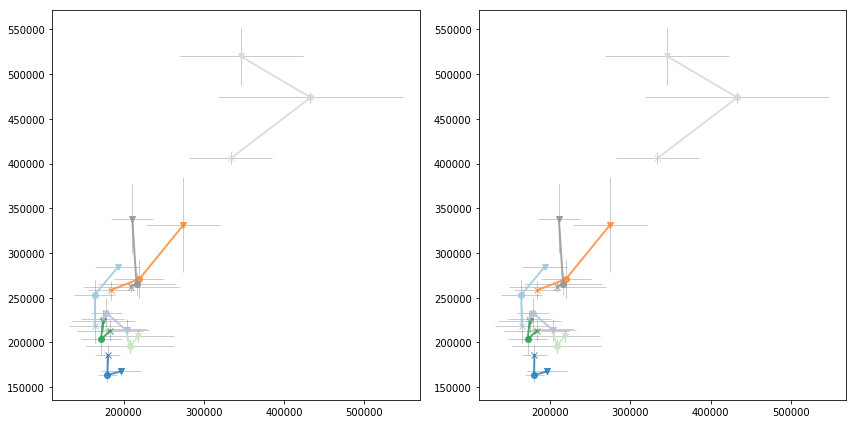

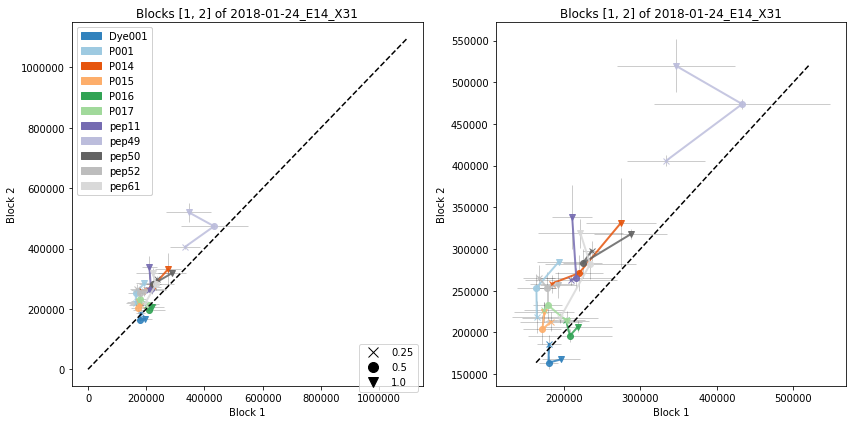

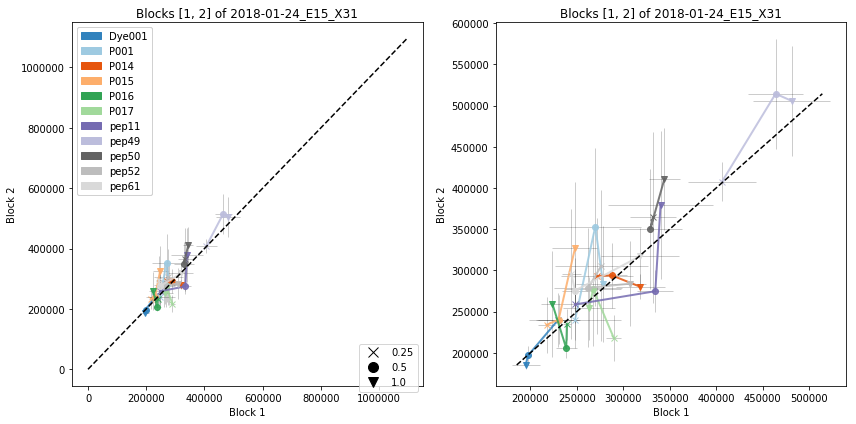

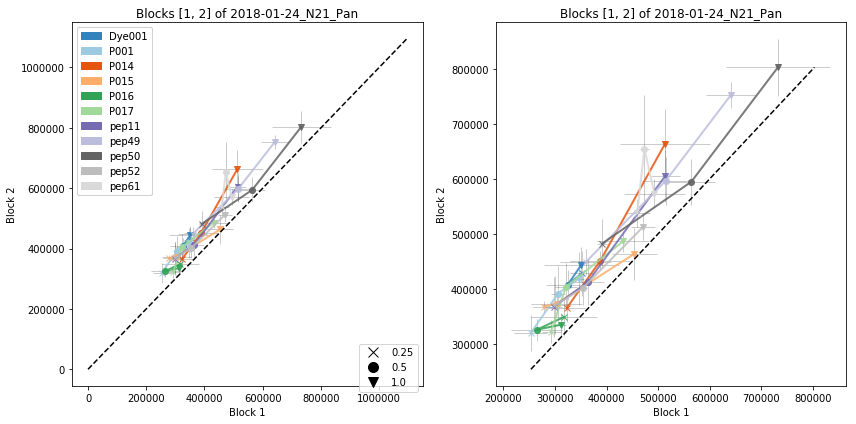

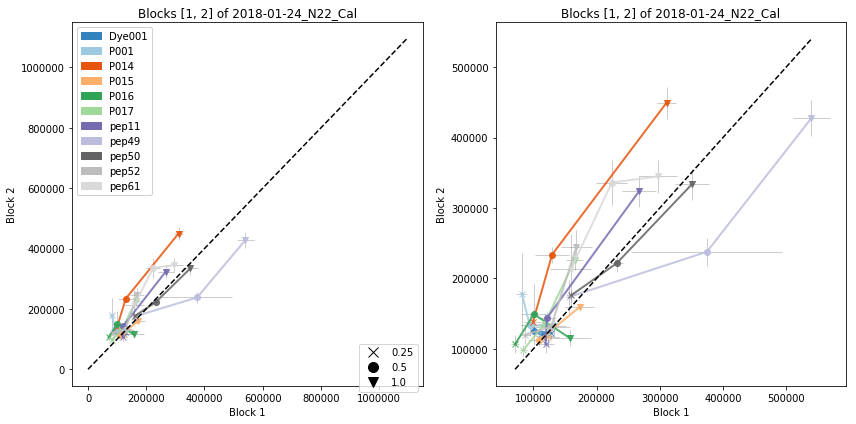

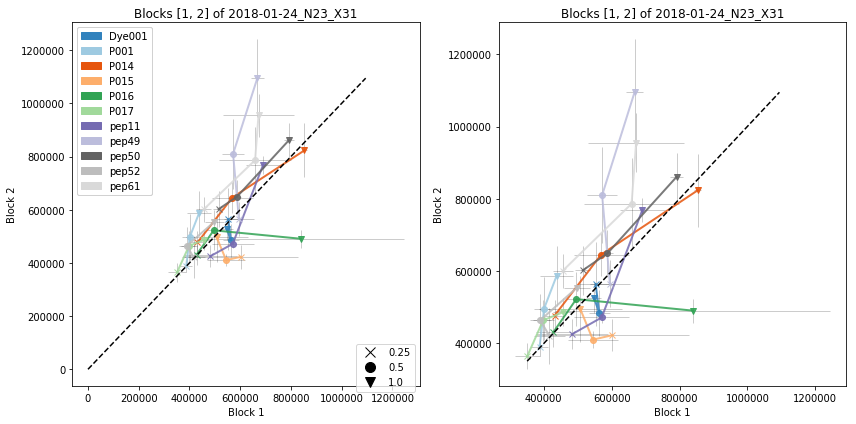

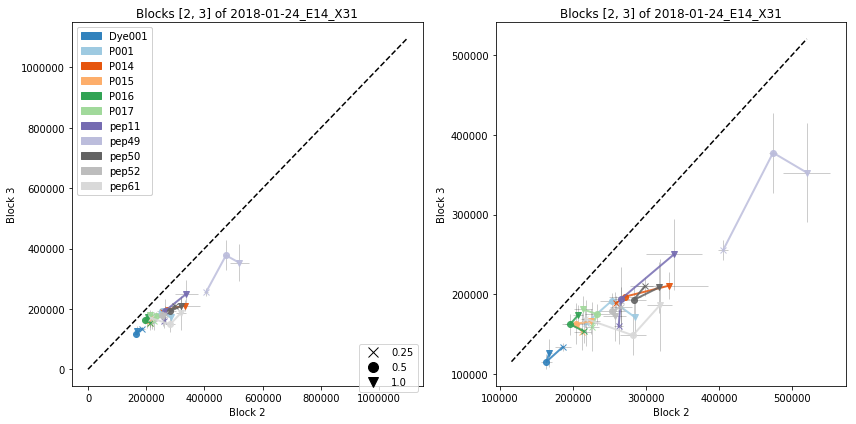

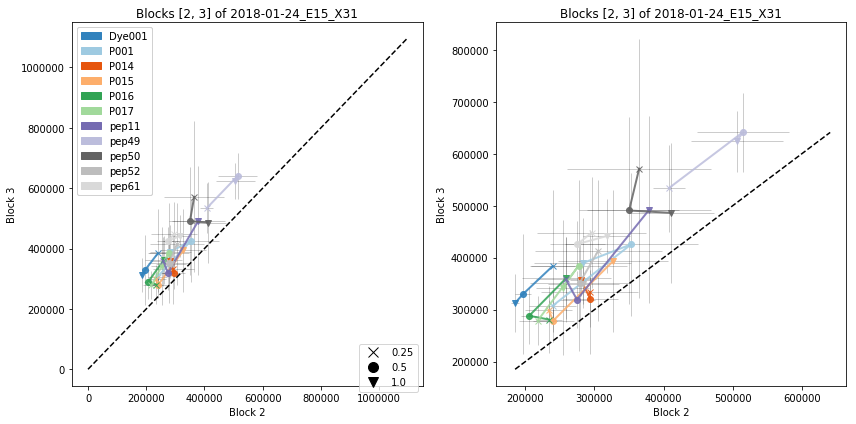

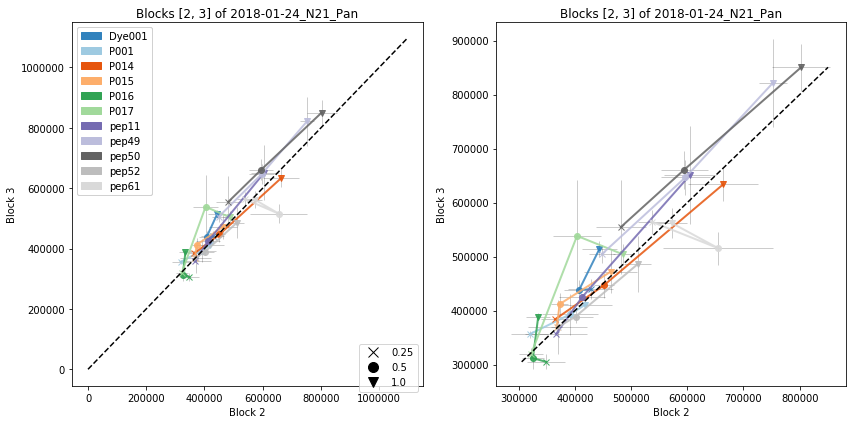

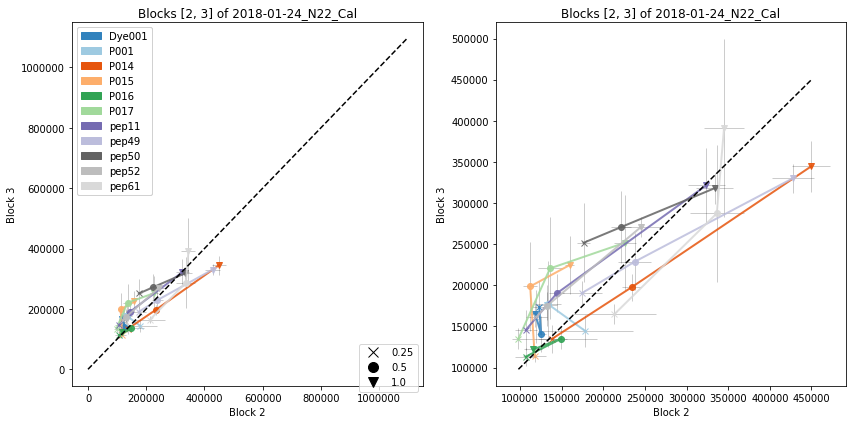

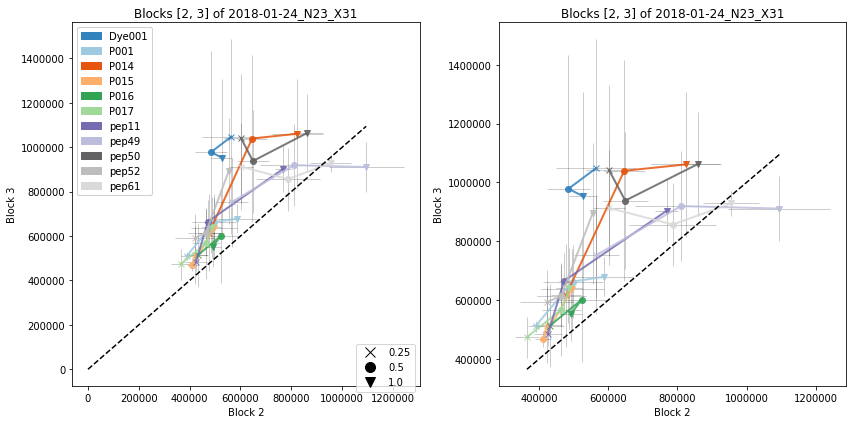

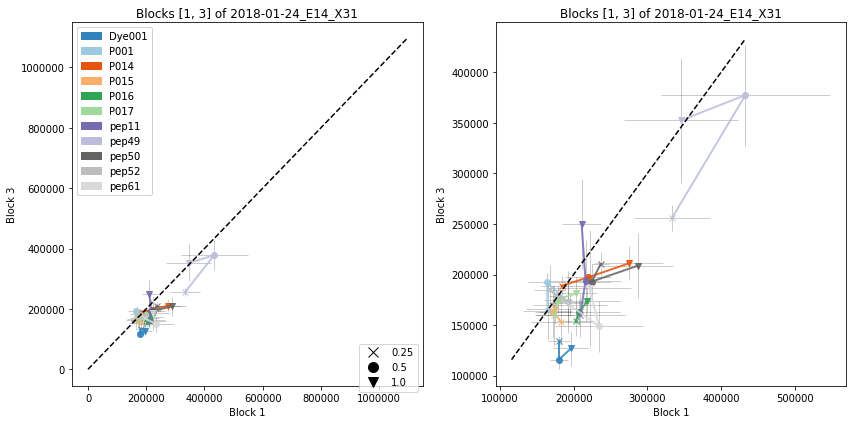

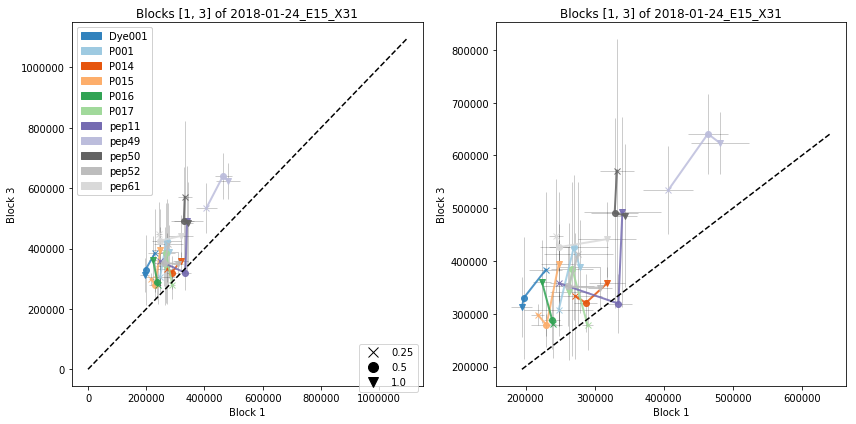

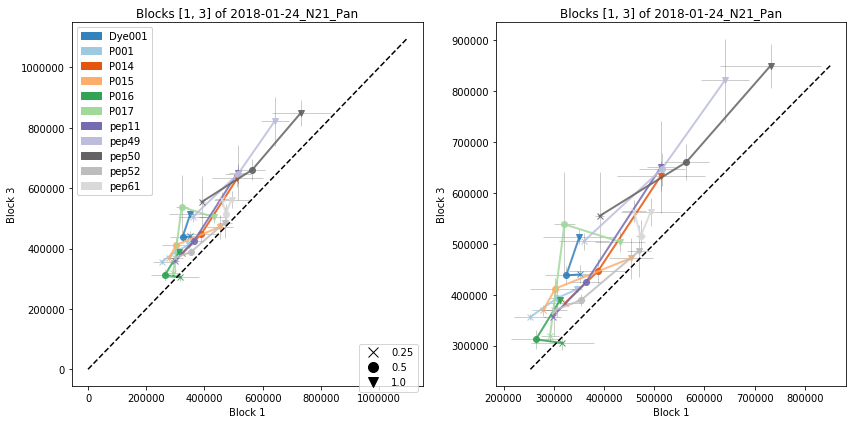

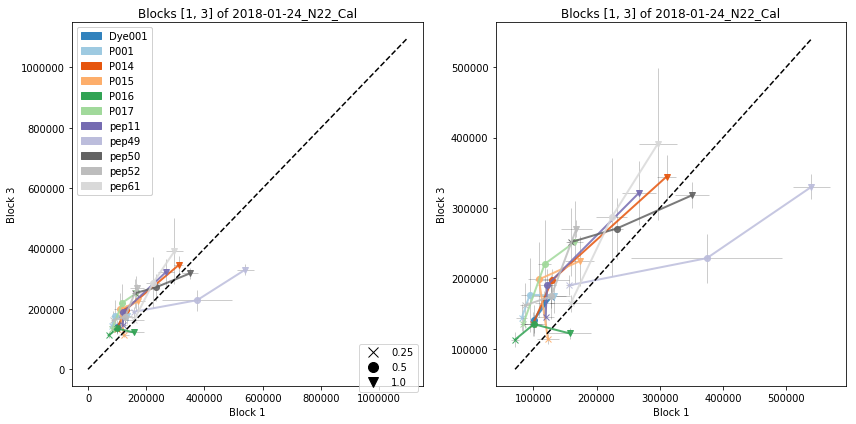

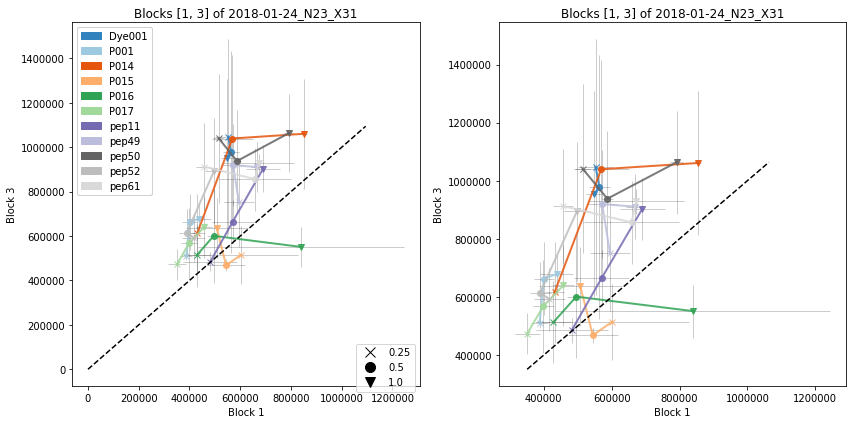

In [311]:
import matplotlib.lines as mlines
from collections import OrderedDict
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

marker = OrderedDict([('x',0.25),('o',0.5),('v',1.0)])

handels_marker = [mlines.Line2D([], [], color='k', marker=m, linestyle='None',markersize=10, label=marker[m]) for m in marker]
blocks = [2,1]
blocks_sets= [[1,2],[2,3],[1,3]]
for blocks in blocks_sets:
    for collection_name, collection_data in test_data.groupby('Collection'):
        color = iter(plt.cm.tab20c(np.linspace(0,1,n)))
        n = len(collection_data.groupby('Ligand').groups)
        handels = []

        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        axes = (ax1, ax2)

        for ligand_name, ligand_data in collection_data.groupby('Ligand'):
            c=next(color)
            patch = mpatches.Patch(color=c, label=ligand_name)
            handels.append(patch)

            for ax in axes:
                marker_it = iter(marker)
                ax.plot(intensity_of_block(ligand_data,blocks[0]),intensity_of_block(ligand_data,blocks[1]),
                         marker=None,alpha=.85,c=c, linewidth=2)

                for lb_name, lb_data in ligand_data.groupby('Ligand Batch Concentration'):
                    m = next(marker_it)


                    x = intensity_of_block(lb_data,blocks[0])
                    y = intensity_of_block(lb_data,blocks[1])
                    x_std = std_of_block(lb_data,blocks[0])
                    y_std = std_of_block(lb_data,blocks[1])
                    ax.errorbar(x, y, xerr=x_std, yerr=y_std,alpha=.4, capthick=2,c="black", linewidth=0.5)
                    ax.plot(x, y, alpha=.9, marker=m, c=c)

        # unzoomed axes
        max_i = test_data["Intensity"].max()
        min_i = test_data["Intensity"].min()
        ax1.plot([0,max_i],[0,max_i], 'k--')

        # zoomed axes
        max_i = collection_data["Intensity"].iloc[[b in blocks for b in collection_data["Block"]]].max()
        min_i = collection_data["Intensity"].iloc[[b in blocks for b in collection_data["Block"]]].min()
        ax2.plot([min_i,max_i],[min_i,max_i], 'k--')

        for ax in (ax1, ):
            l1 = ax.legend(handles=handels_marker,bbox_to_anchor=(1.0, 0.13))
            l2 = ax.legend(handles=handels)
            ax.add_artist(l1)
            ax.add_artist(l2)

        for ax in axes:
            ax.set_xlabel('Block {}'.format(blocks[0]))
            ax.set_ylabel('Block {}'.format(blocks[1]))
            ax.set_title('Blocks {} of {}'.format(blocks,collection_name))
        plt.savefig('{}_blocks_{}_mean_on_block'.format(collection_name,blocks))
        plt.show()
    
        

In [ ]:
def f(x,h):
    return x+h
    



495

In [397]:
plot_data = copy.deepcopy(raw_data)
#display(plot_data)

test_data = plot_data.groupby(['Collection','Block', 'Ligand Batch','Ligand']).mean()
test_data["Std"]=plot_data.groupby(['Collection','Block', 'Ligand Batch','Ligand'])['Intensity'].std()/np.sqrt(3)
test_data.reset_index(inplace=True)
print(len(test_data))
#test_data= test_data[[collection in ["2018-01-24_E14_X31","2018-01-24_E15_X31"] for collection in test_data.Collection]]
print(len(test_data))

495
495


In [327]:
#test_data = plot_data


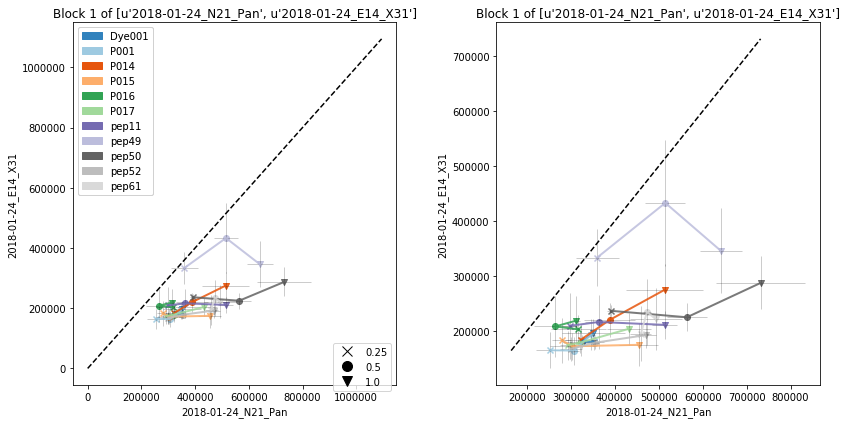

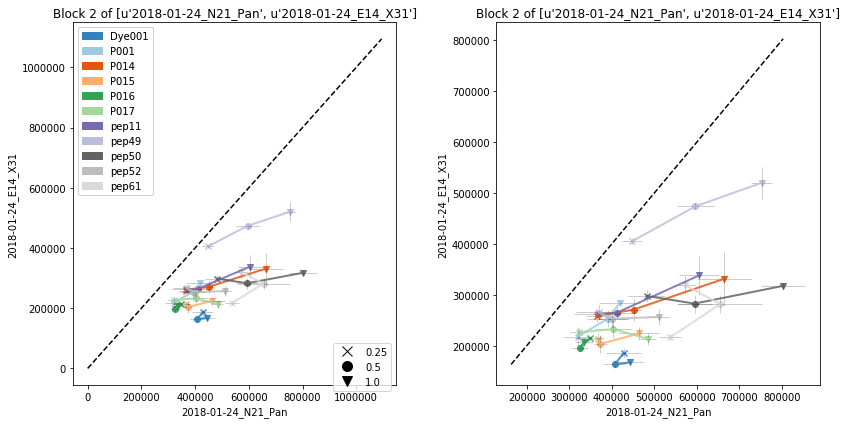

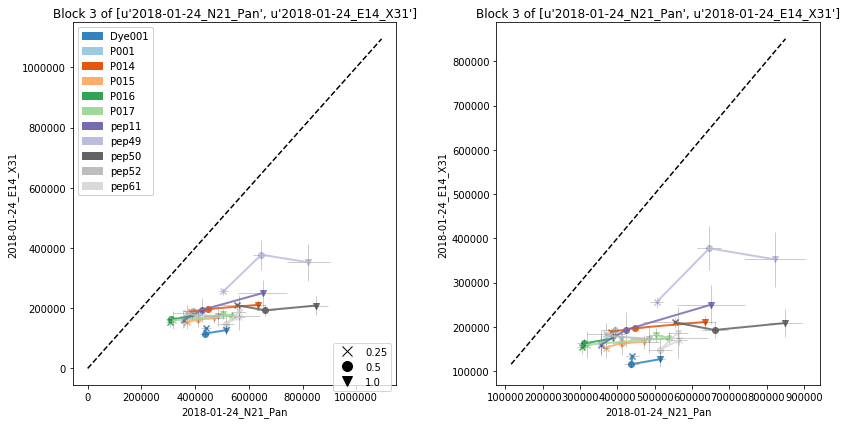

In [399]:

import matplotlib.lines as mlines
from collections import OrderedDict
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

marker = OrderedDict([('x',0.25),('o',0.5),('v',1.0)])

handels_marker = [mlines.Line2D([], [], color='k', marker=m, linestyle='None',markersize=10, label=marker[m]) for m in marker]
collections = ["2018-01-24_N21_Pan","2018-01-24_E14_X31",]

for block_name, block_data in test_data.groupby('Block'):
    color = iter(plt.cm.tab20c(np.linspace(0,1,n)))
    n = len(block_data.groupby('Ligand').groups)
    handels = []

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    axes = (ax1, ax2)

    for ligand_name, ligand_data in block_data.groupby('Ligand'):
        c=next(color)
        patch = mpatches.Patch(color=c, label=ligand_name)
        handels.append(patch)

        for ax in axes:
            marker_it = iter(marker)
            x = ligand_data[ligand_data["Collection"]==collections[0]]["Intensity"]
            y = ligand_data[ligand_data["Collection"]==collections[1]]["Intensity"]
            ax.plot(x,y,marker=None,alpha=.85,c=c, linewidth=2)

            for lb_name, lb_data in ligand_data.groupby('Ligand Batch Concentration'):
                m = next(marker_it)


                x = lb_data[lb_data["Collection"]==collections[0]]["Intensity"]
                y = lb_data[lb_data["Collection"]==collections[1]]["Intensity"]
                x_std = lb_data[lb_data["Collection"]==collections[0]]["Std"]
                y_std = lb_data[lb_data["Collection"]==collections[1]]["Std"]
                ax.errorbar(x, y, xerr=x_std, yerr=y_std,alpha=.4, capthick=2,c="black", linewidth=0.5)
                ax.scatter(x, y, alpha=.9, marker=m, c=c)
                

    # unzoomed axes
    max_i = test_data["Intensity"].max()
    min_i = test_data["Intensity"].min()
    ax1.plot([0,max_i],[0,max_i], 'k--')

    # zoomed axes
    max_i = block_data[[collection in collections for collection in block_data.Collection]]["Intensity"].max()
    min_i = block_data[[collection in collections for collection in block_data.Collection]]["Intensity"].min()
    ax2.plot([min_i,max_i],[min_i,max_i], 'k--')

    for ax in (ax1, ):
        l1 = ax.legend(handles=handels_marker,bbox_to_anchor=(1.0, 0.13))
        l2 = ax.legend(handles=handels)
        ax.add_artist(l1)
        ax.add_artist(l2)

    for ax in axes:
        ax.set_xlabel('{}'.format(collections[0]))
        ax.set_ylabel('{}'.format(collections[1]))
        ax.set_title('Block {} of {}'.format(block_name,collections))
    #plt.savefig('{}_bloch_{}_mean_on_block'.format(block_name,blocks))
    plt.show()

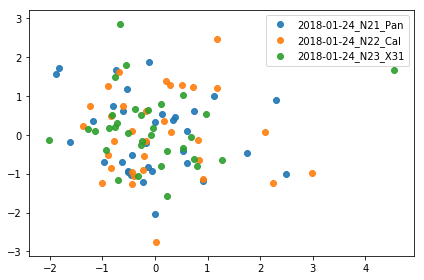

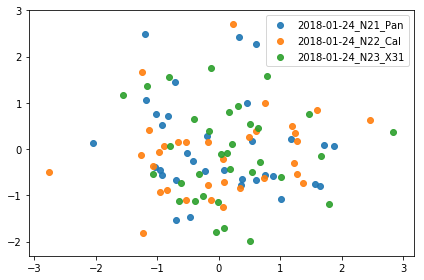

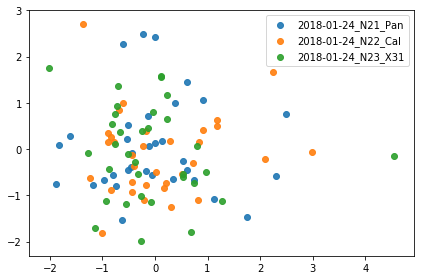

In [412]:
blocks_sets= [[1,2],[2,3],[1,3]]
for blocks in blocks_sets:
    plt.figure()
    
    for collection_name, collection_data in normalized_data.groupby('Collection'):
        if "_E1" in collection_name:
            continue
        x = intensity_of_block(collection_data,blocks[0])
        y = intensity_of_block(collection_data,blocks[1])
        plt.scatter(x, y, alpha=.9, label=collection_name)
    plt.legend() 
    
    plt.show()

In [413]:
plot_data = copy.deepcopy(normalized_data)
#display(plot_data)

test_data = plot_data.groupby(['Collection','Block','Ligand']).mean()
test_data["Std"]=plot_data.groupby(['Collection','Block','Ligand'])['Intensity'].std()/np.sqrt(3)
test_data.reset_index(inplace=True)
print(len(test_data))
#test_data= test_data[[collection in ["2018-01-24_E14_X31","2018-01-24_E15_X31"] for collection in test_data.Collection]]
print(len(test_data))

165
165


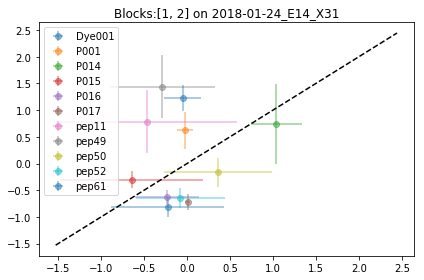

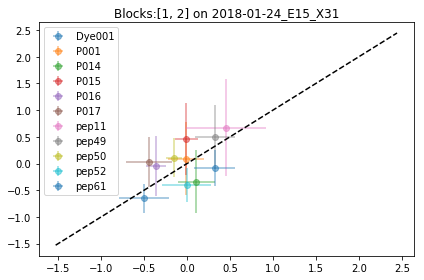

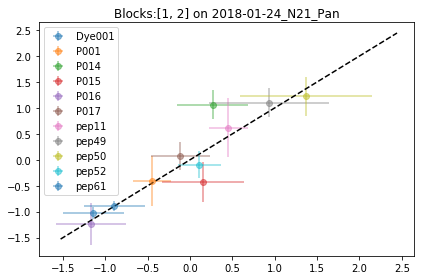

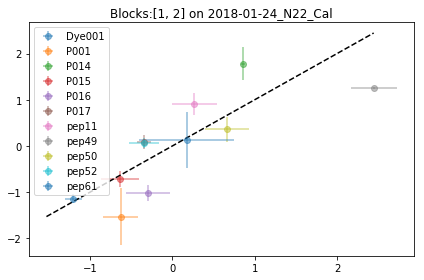

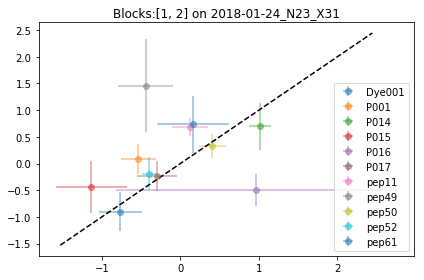

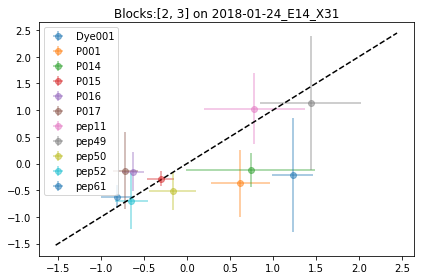

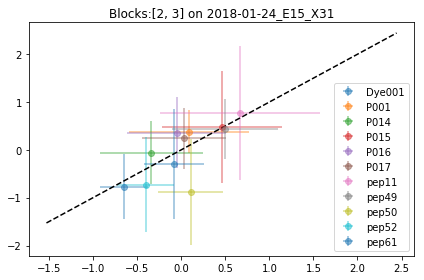

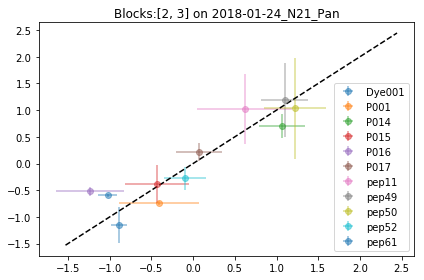

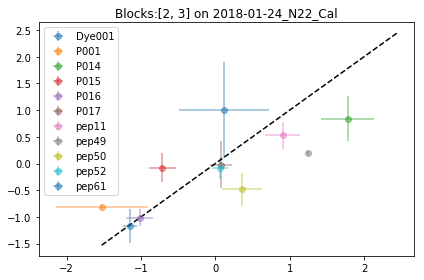

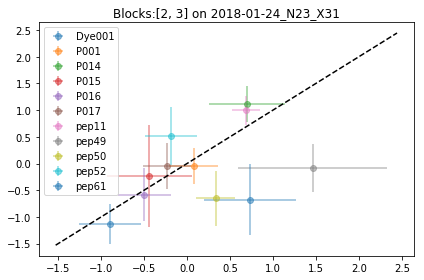

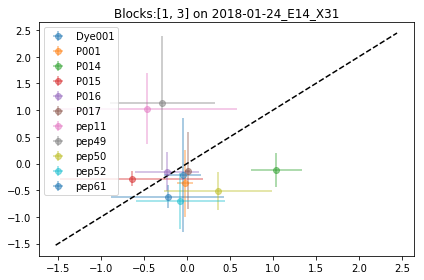

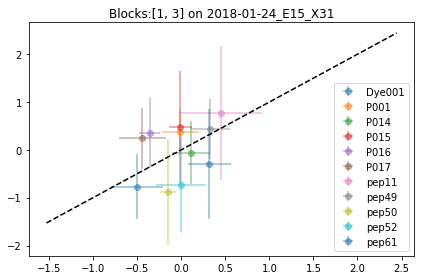

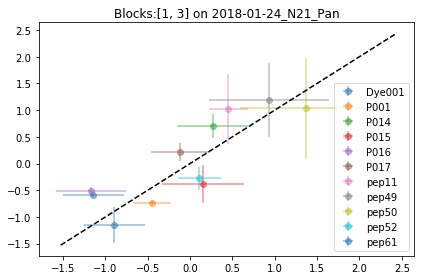

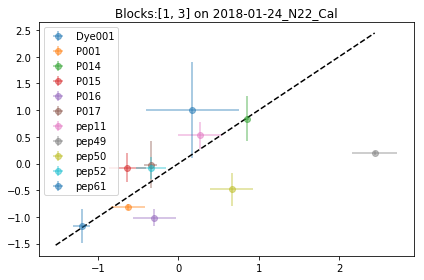

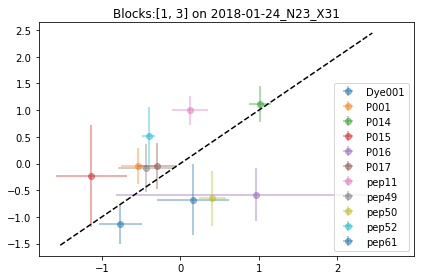

In [414]:
blocks_sets= [[1,2],[2,3],[1,3]]
for blocks in blocks_sets:
    
    for collection_name, collection_data in test_data.groupby('Collection'):
        plt.figure()
        for ligand_name, ligand_data in collection_data.groupby('Ligand'):
            x = intensity_of_block(ligand_data,blocks[0])
            y = intensity_of_block(ligand_data,blocks[1])
            x_std = std_of_block(ligand_data,blocks[0])
            y_std = std_of_block(ligand_data,blocks[1])
            plt.errorbar(x, y, xerr=x_std, yerr=y_std,alpha=0.5, fmt='o',label=ligand_name)
            
        max_i = test_data["Intensity"].max()
        min_i = test_data["Intensity"].min()
        plt.title("Blocks:{} on {}".format(blocks,collection_name))
        plt.plot([min_i,max_i],[min_i,max_i], 'k--')
        plt.legend() 

        plt.show()

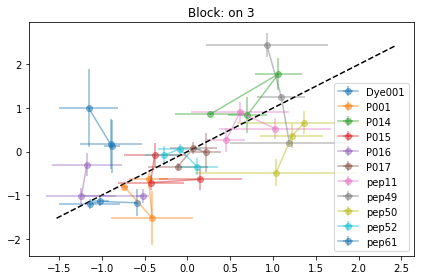

In [417]:
collections_sets= [["2018-01-24_N21_Pan","2018-01-24_N22_Cal"],]
for collection in collections_sets:
    #for block_name, block_data in test_data.groupby('Block'):
        plt.figure()
        for ligand_name, ligand_data in test_data.groupby('Ligand'):
            x = ligand_data[ligand_data['Collection']==collection[0]]["Intensity"]
            y = ligand_data[ligand_data['Collection']==collection[1]]["Intensity"]
            x_std = ligand_data[ligand_data['Collection']==collection[0]]["Std"]
            y_std = ligand_data[ligand_data['Collection']==collection[1]]["Std"]
            plt.errorbar(x, y, xerr=x_std, yerr=y_std,alpha=0.5, marker='o',label=ligand_name)
            
        max_i = test_data["Intensity"].max()
        min_i = test_data["Intensity"].min()
        plt.title("Block: on {}".format(block_name,collection))
        plt.plot([min_i,max_i],[min_i,max_i], 'k--')
        plt.legend() 

        plt.show()

In [418]:
plot_data = copy.deepcopy(constructed_data)
#display(plot_data)

test_data = plot_data.groupby(['Collection','Block','Ligand']).mean()
test_data["Std"]=plot_data.groupby(['Collection','Block','Ligand'])['Intensity'].std()/np.sqrt(3)
test_data.reset_index(inplace=True)
print(len(test_data))
#test_data= test_data[[collection in ["2018-01-24_E14_X31","2018-01-24_E15_X31"] for collection in test_data.Collection]]
print(len(test_data))

165
165


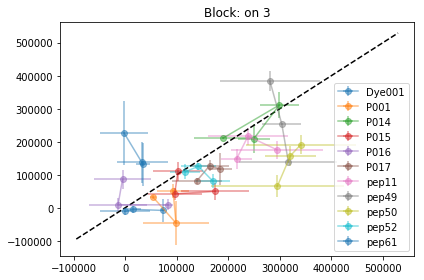

In [419]:
collections_sets= [["2018-01-24_N21_Pan","2018-01-24_N22_Cal"],]
for collection in collections_sets:
    #for block_name, block_data in test_data.groupby('Block'):
        plt.figure()
        for ligand_name, ligand_data in test_data.groupby('Ligand'):
            x = ligand_data[ligand_data['Collection']==collection[0]]["Intensity"]
            y = ligand_data[ligand_data['Collection']==collection[1]]["Intensity"]
            x_std = ligand_data[ligand_data['Collection']==collection[0]]["Std"]
            y_std = ligand_data[ligand_data['Collection']==collection[1]]["Std"]
            plt.errorbar(x, y, xerr=x_std, yerr=y_std,alpha=0.5, marker='o',label=ligand_name)
            
        max_i = test_data["Intensity"].max()
        min_i = test_data["Intensity"].min()
        plt.title("Block: on {}".format(block_name,collection))
        plt.plot([min_i,max_i],[min_i,max_i], 'k--')
        plt.legend() 

        plt.show()